In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from time import time
from sklearn.cluster import KMeans

%matplotlib inline

In [6]:
def load_image_to_array(filename, with_alpha=False, resize_factor=None, min_side=None, max_side=None):
    image = Image.open(filename)
    width, height = image.width, image.height
    
    if resize_factor != None:
        new_width = int(resize_factor * width)
        new_height = int(resize_factor * height)
        image = image.resize((new_width, new_height))
    elif (min_side == None) or (max_side == None):
        width_is_min = (width < height)
            
        if (min_side != None) and (max_side != None):
            if width_is_min:
                image = image.resize((min_side, max_side))
            else:
                image = image.resize((max_side, min_side))
        elif min_side != None:
            if width_is_min:
                new_height = int(height * min_side / width)
                image = image.resize((min_side, new_height))
            else:
                new_width = int(width * min_side / height)
                image = image.resize((new_width, min_side))
        elif max_side != None:
            if width_is_min:
                new_width = int(width * max_side / height)
                image = image.resize((new_width, max_side))
            else:
                new_height = int(height * max_side / width)
                image = image.resize((max_side, new_height))
                
    image = np.array(image)
    if (not with_alpha) and (image.shape[-1] == 4):
        image = image[:, :, :-1]

    return image

def get_palette(image, K=10):
    image = np.array(image, dtype='float32')
    image_shape = image.shape
    image = image.reshape(-1, 3)
    
    kmeans = KMeans(n_clusters=K, random_state=0, n_init=3, max_iter=100)
    kmeans.fit(image)
    clusters = kmeans.predict(image)
    result = kmeans.cluster_centers_[clusters]
    
    result = np.uint8(result) 
    result = result.reshape(image_shape)
    image = np.uint8(image)
    image = image.reshape(image_shape)
    
    return image, result, kmeans

def sideplot(image, result, tag=('original', 'result'), figsize=(8, 4), title=None):
    fig, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].imshow(image)
    ax[0].axis('off')
    ax[0].set_title(tag[0])
    ax[1].imshow(result)
    ax[1].axis('off')
    ax[1].set_title(tag[1])
    fig.tight_layout()
    if title:
        fig.suptitle(title)
        plt.savefig('images/%s.jpg' % title)
    plt.show()
    
def fourplot(image1, image2, result1, image_cross):
    fig, ax = plt.subplots(2, 2, figsize=(8, 8))

    ax[0][0].imshow(image1)
    ax[0][0].set_title('Image 1')
    ax[0][0].axis('off')

    ax[0][1].imshow(image2)
    ax[0][1].set_title('Image 2')
    ax[0][1].axis('off')

    ax[1][0].imshow(result1)
    ax[1][0].set_title('Image 1 with palette')
    ax[1][0].axis('off')

    ax[1][1].imshow(image_cross)
    ax[1][1].set_title('Transferred palette')
    ax[1][1].axis('off')

    fig.tight_layout()
    plt.show()
    
def transfer_palette(image1, image2, K=10):
    start = time()
    image1, result1, algo1 = get_palette(image1, K=K)

    orig_shape = image2.shape
    image_cross = image2.reshape(-1, image2.shape[-1])
    clusters = algo1.predict(image_cross)
    image_cross = algo1.cluster_centers_[clusters]
    image_cross = np.uint8(image_cross.reshape(orig_shape))
    
    print('Done in %.2fs' % (time() - start))
    
    return (
        image_cross,
        result1,
        algo1
    )

Done in 7.24s


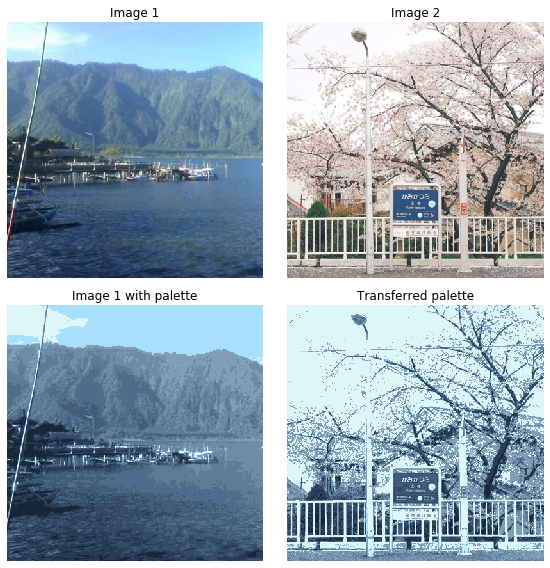

In [7]:
filename1, filename2 = 'images/bali.png', 'images/blossom.jpg'
image1 = load_image_to_array(filename1, min_side=400)
image2 = load_image_to_array(filename2, min_side=400)

image_cross, result, algo = transfer_palette(image1, image2, K=10)
fourplot(image1, image2, result, image_cross)

Done in 3.04s
Done in 3.64s
Done in 10.79s


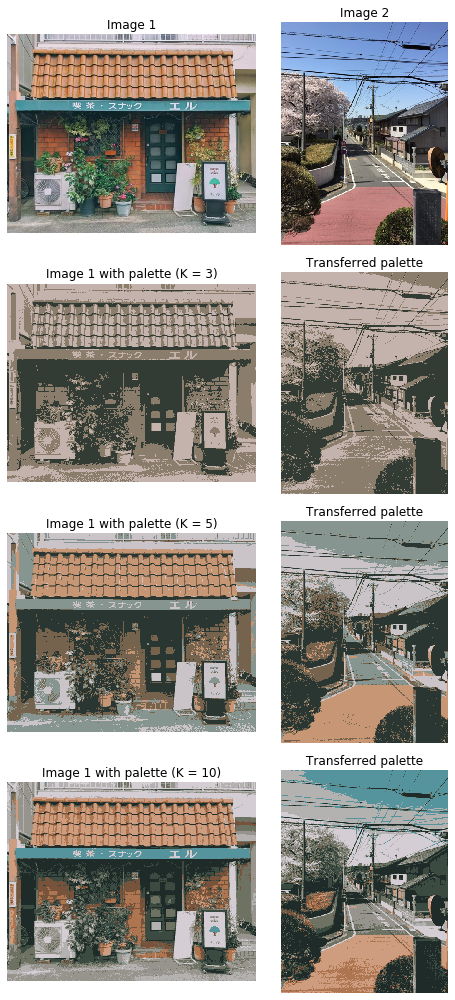

In [22]:
filename1 = 'images/house.jpg'
filename2 = 'images/street4.jpg'
image1 = load_image_to_array(filename1, min_side=400)
image2 = load_image_to_array(filename2, min_side=400)

list_K = [3, 5, 10]
N, width = len(list_K) + 1, 7
fig, ax = plt.subplots(N, 2, figsize=(width, width * 2))

ax[0][0].imshow(image1)
ax[0][0].set_title('Image 1')
ax[0][0].axis('off')

ax[0][1].imshow(image2)
ax[0][1].set_title('Image 2')
ax[0][1].axis('off')

for i, K in enumerate(list_K):
    image_cross, result, algo = transfer_palette(image1, image2, K=K)
    
    ax[i + 1][0].imshow(result)
    ax[i + 1][0].set_title('Image 1 with palette (K = %d)' % K)
    ax[i + 1][0].axis('off')

    ax[i + 1][1].imshow(image_cross)
    ax[i + 1][1].set_title('Transferred palette')
    ax[i + 1][1].axis('off')

fig.tight_layout()
plt.savefig('result.jpg')